In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from numba import prange
import statsmodels.api as sm

In [3]:
import warnings

warnings.filterwarnings('ignore')

# 1. Data Preprocessing

In [3]:
# Load df
sheet1 = pd.read_csv('../raw_data/weekly_price_turnover/TRD_Week.csv')
sheet2 = pd.read_csv('../raw_data/weekly_price_turnover/TRD_Week1.csv')
sheet3 = pd.read_csv('../raw_data/weekly_price_turnover/TRD_Week2.csv')
sheet4 = pd.read_csv('../raw_data/weekly_price_turnover/TRD_Week3.csv')
blacklist = pd.read_pickle('../raw_data/BLACKLIST.pkl')
untradable = pd.read_pickle('../raw_data/UNTRADABLE.pkl')

In [4]:
# Concatenate the 4 sheets
df1 = pd.concat([sheet1, sheet2, sheet3, sheet4])
df1.rename(columns={'Stkcd': 'asset', 'Trdwnt': 'week', 'Wclsprc': 'weekly_close', 'Wsmvosd': 'weekly_negotiable_value', 'Clsdt': 'weekly_closing_date', 'Wnshrtrd': 'weekly_traded_shares'}, inplace=True)
# filter out the stocks with weekly_close price < 5
df1 = df1[df1['weekly_close'] >= 5]

df1 = df1.dropna()
# Exclude 北交所, which means asset codes begin with 43, 83, 87, 88
df1 = df1[~df1['asset'].astype(str).str.startswith(('43', '83', '87', '88'))]
df1['asset'] = df1['asset'].astype(int)
df1['weekly_negotiable_value'] = df1['weekly_negotiable_value'].astype(float)

df1['weekly_turnover'] = (df1['weekly_traded_shares'] / (df1['weekly_negotiable_value'] * 1000 / df1['weekly_close'])).round(4)
df1 = df1.dropna()
df1['weekly_turnover'] = df1['weekly_turnover'].astype(float)

# first we try a small time range (2020-01-01, 2024-01-01), \
    # since the time cost of the current algorithm is too high to run across all data from 1991-2024, will consider how to improve it later
df1['weekly_closing_date'] = pd.to_datetime(df1['weekly_closing_date'])
# df1 = df1[(df1['weekly_closing_date'] >= '2020-01-01') & (df1['weekly_closing_date'] <= '2024-12-01')]
df1 = df1.reset_index()

df1

,index,asset,week,weekly_closing_date,weekly_close,weekly_traded_shares,weekly_negotiable_value,weekly_turnover
0,0,1,1991-14,1991-04-06,48.28,1300,1279420.00,0.0000
1,1,1,1991-15,1991-04-13,46.84,3400,1241260.00,0.0001
2,2,1,1991-16,1991-04-20,45.46,1400,1204690.00,0.0001
3,3,1,1991-17,1991-04-26,44.34,6700,1175010.00,0.0003
4,4,1,1991-18,1991-05-04,43.02,1300,1140030.00,0.0000
...,...,...,...,...,...,...,...,...
2794862,312923,689009,2024-44,2024-11-01,45.57,53367558,2489898.50,0.9767
2794863,312924,689009,2024-45,2024-11-08,47.01,71438687,2568578.64,1.3075
2794864,312925,689009,2024-46,2024-11-15,47.54,65408553,2597537.30,1.1971
2794865,312926,689009,2024-47,2024-11-22,43.06,42720743,2352754.65,0.7819


In [5]:
# Preprocess blacklist
blacklist = blacklist.reset_index()
blacklist['is_blacklist'] = 1
blacklist['asset'] = blacklist['asset'].astype(str)
blacklist['asset'] = blacklist['asset'].str.extract(r'(\d+)')
blacklist['asset'] = blacklist['asset'].astype(int) 
blacklist['date'] = pd.to_datetime(blacklist['date'])
blacklist['week'] = blacklist['date'].dt.strftime('%Y-%W').apply(lambda x: f"{x[:5]}{int(x[5:]) + 1:02d}")

# Keep only the last 'date' record for each 'week' and 'asset'
last_dates = blacklist.groupby('week')['date'].max().reset_index()
# This will ensure the week information align with the price and monthly_turnover rate
blacklist_prep = pd.merge(blacklist, last_dates, on=['week', 'date'])
blacklist_prep

,date,asset,is_blacklist,week
0,1991-12-20,1,1,1991-51
1,1991-12-20,2,1,1991-51
2,1991-12-20,3,1,1991-51
3,1991-12-20,4,1,1991-51
4,1991-12-20,9,1,1991-51
...,...,...,...,...
452998,2024-09-11,873833,1,2024-38
452999,2024-09-11,900952,1,2024-38
453000,2024-09-11,920002,1,2024-38
453001,2024-09-11,920008,1,2024-38


In [6]:
# Preprocess untradable
untradable = untradable.reset_index()
untradable['is_untradable'] = 1
untradable['asset'] = untradable['asset'].astype(str)
untradable['asset'] = untradable['asset'].str.extract(r'(\d+)')  # Extracts only the numeric part of the string, \
untradable['asset'] = untradable['asset'].astype(int)              # to align with the stock codes in the price and monthly_turnover df
untradable['date'] = pd.to_datetime(untradable['date'])
untradable['week'] = untradable['date'].dt.strftime('%Y-%W').apply(lambda x: f"{x[:5]}{int(x[5:]) + 1:02d}")

# Keep only the last 'date' record for each 'week' and 'asset'
last_dates = untradable.groupby('week')['date'].max().reset_index()
# This will ensure the week information align with the price and monthly_turnover rate
untradable_prep = pd.merge(untradable, last_dates, on=['week', 'date'])
untradable_prep

,date,asset,is_untradable,week
0,1990-12-21,600601,1,1990-52
1,1990-12-21,600651,1,1990-52
2,1990-12-21,600654,1,1990-52
3,1990-12-21,600656,1,1990-52
4,1990-12-28,600601,1,1990-53
...,...,...,...,...
131653,2024-09-11,601989,1,2024-38
131654,2024-09-11,603007,1,2024-38
131655,2024-09-11,603626,1,2024-38
131656,2024-09-11,603883,1,2024-38


In [7]:
# Merge the with the blacklist and untradable, only merge the 'is_blacklist' and 'is_untradable' columns, fill the NaN with 0

df2 = pd.merge(df1, blacklist_prep[['asset', 'week', 'is_blacklist']], on=['asset', 'week'], how='left')
df2 = pd.merge(df2, untradable_prep[['asset', 'week', 'is_untradable']], on=['asset', 'week'], how='left')

df2['weekly_close'] = df2['weekly_close'].astype(float)
df2['weekly_turnover'] = df2['weekly_turnover'].astype(float)

df2

,index,asset,week,weekly_closing_date,weekly_close,weekly_traded_shares,weekly_negotiable_value,weekly_turnover,is_blacklist,is_untradable
0,0,1,1991-14,1991-04-06,48.28,1300,1279420.00,0.0000,NaN,1.0
1,1,1,1991-15,1991-04-13,46.84,3400,1241260.00,0.0001,NaN,1.0
2,2,1,1991-16,1991-04-20,45.46,1400,1204690.00,0.0001,NaN,1.0
3,3,1,1991-17,1991-04-26,44.34,6700,1175010.00,0.0003,NaN,1.0
4,4,1,1991-18,1991-05-04,43.02,1300,1140030.00,0.0000,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
2794862,312923,689009,2024-44,2024-11-01,45.57,53367558,2489898.50,0.9767,NaN,NaN
2794863,312924,689009,2024-45,2024-11-08,47.01,71438687,2568578.64,1.3075,NaN,NaN
2794864,312925,689009,2024-46,2024-11-15,47.54,65408553,2597537.30,1.1971,NaN,NaN
2794865,312926,689009,2024-47,2024-11-22,43.06,42720743,2352754.65,0.7819,NaN,NaN


In [8]:
# Prepare another df3 to exclude stocks that are in blacklist and untradable, remain df2 unchanged in case we may have some other usages
df3 = df2[(df2['is_blacklist'] != 1) & (df2['is_untradable'] != 1)]
df3 = df3.drop(columns=['is_blacklist', 'is_untradable'])
df3 = df3.reset_index(drop=True)

df3

,index,asset,week,weekly_closing_date,weekly_close,weekly_traded_shares,weekly_negotiable_value,weekly_turnover
0,14,1,1991-28,1991-07-11,32.17,1600,852505.00,0.0001
1,18,1,1991-33,1991-08-17,15.80,32800,710824.95,0.0007
2,19,1,1991-34,1991-08-24,15.60,1905200,701827.17,0.0423
3,20,1,1991-35,1991-08-31,15.00,1304300,674833.82,0.0290
4,21,1,1991-36,1991-09-07,13.85,1854200,623096.56,0.0412
...,...,...,...,...,...,...,...,...
2438399,312923,689009,2024-44,2024-11-01,45.57,53367558,2489898.50,0.9767
2438400,312924,689009,2024-45,2024-11-08,47.01,71438687,2568578.64,1.3075
2438401,312925,689009,2024-46,2024-11-15,47.54,65408553,2597537.30,1.1971
2438402,312926,689009,2024-47,2024-11-22,43.06,42720743,2352754.65,0.7819


In [9]:
print(len(df3['asset'].unique()))

# Eliminate the stocks that have less than 260 weeks (5 years) of data, to ensure we have enough data to calculate the CGO as required
# so if an asset has less than 260 records, we will directly exclude it
asset_counts = df3['asset'].value_counts()
asset_counts = asset_counts[asset_counts >= 260]
df3 = df3[df3['asset'].isin(asset_counts.index)]

df3 = df3.drop(columns=['index', 'weekly_traded_shares', 'weekly_negotiable_value'])

df3 = df3.reset_index(drop=True)

print(len(df3['asset'].unique()))
df3.to_csv('../preprocessed_data/whole_df3.csv', index=False)

display(df3)


5368
3448


,asset,week,weekly_closing_date,weekly_close,weekly_turnover
0,1,1991-28,1991-07-11,32.17,0.0001
1,1,1991-33,1991-08-17,15.80,0.0007
2,1,1991-34,1991-08-24,15.60,0.0423
3,1,1991-35,1991-08-31,15.00,0.0290
4,1,1991-36,1991-09-07,13.85,0.0412
...,...,...,...,...,...
2208934,603999,2024-44,2024-11-01,5.64,0.0980
2208935,603999,2024-45,2024-11-08,5.99,0.0767
2208936,603999,2024-46,2024-11-15,5.97,0.0886
2208937,603999,2024-47,2024-11-22,5.95,0.1044


In [10]:
# Prepare another df4 to exclude stocks that have less than 520 weeks (10 years) of data
df4 = df3.copy()
asset_counts = df4['asset'].value_counts()
asset_counts = asset_counts[asset_counts >= 520]
df4 = df4[df4['asset'].isin(asset_counts.index)]

df4 = df4.reset_index(drop=True)

print(len(df4['asset'].unique()))
df4.to_csv('../preprocessed_data/whole_df4.csv', index=False)

display(df4)

1930


,asset,week,weekly_closing_date,weekly_close,weekly_turnover
0,1,1991-28,1991-07-11,32.17,0.0001
1,1,1991-33,1991-08-17,15.80,0.0007
2,1,1991-34,1991-08-24,15.60,0.0423
3,1,1991-35,1991-08-31,15.00,0.0290
4,1,1991-36,1991-09-07,13.85,0.0412
...,...,...,...,...,...
1640689,603167,2024-44,2024-11-01,8.39,0.0819
1640690,603167,2024-45,2024-11-08,8.73,0.0900
1640691,603167,2024-46,2024-11-15,8.66,0.0742
1640692,603167,2024-47,2024-11-22,8.50,0.1621


# 2. Preparing Key Variables 
- 2.1. computing RP and CGO, preprocessing additional data, 
- 2.2. preparing different risk proxies measurements including:
    - Beta (CAPM, 5-year monthly rolling window as in Fama and French (1992) to estimate the market beta for individual firms, at least 2 years of data)
    - RETVOL (return volatility, standard deviation of the previous 5-year monthly returns, at least 2 years of data)
    - IVOL (idiosyncratic stock return volatility, the standard deviation of the residual values from the time-series model:
            R_i,t = b0 + b1*R_M,t + b2*SMB_t + b3*HML_t + ε_i,t )
    - AGE (firm age, the number of years since the firm’s first appearance in stock market until the portfolio formation date)
    - CFVOL (cash flow volatility, standard deviation of cash flow over the previous 5 years.)

## 2.1. Calculating RP and CGO

In [5]:
'''
    RP and CGO
    
    The calculation of RP and CGO are in the python file named 'CGO_multiprocessing.py', it calculates the final results of RP and CGO
        the result is stored in the 'preprocessed_data' folder as 'result_df_more_than_5_years_stocks.csv'
        you can check the 'CGO_multiprocessing.py' file for the code of the calculation process.
'''

# Load the result_df_more_than_5_years_stocks.csv
CGO_df = pd.read_csv('../preprocessed_data/result_df_more_than_10_years_stocks.csv')
CGO_df.info()

# Exclude the 100 weeks (null values) of each stock at the beginning of the first calculation of RP and CGO, \
    # since we need enough initial data to form these two statistics
weekly_CGO_df = CGO_df.copy().dropna()
weekly_CGO_df = weekly_CGO_df.reset_index(drop=True)
weekly_CGO_df = weekly_CGO_df.drop(columns=['RP'])
weekly_CGO_df['weekly_closing_date'] = pd.to_datetime(weekly_CGO_df['weekly_closing_date'])

print(len(weekly_CGO_df['asset'].unique()))
display(weekly_CGO_df)

# Prepare the monthly CGO by keeping only the last week record of each month for each stock

# Extract the year-month for grouping
weekly_CGO_df['year_month'] = weekly_CGO_df['weekly_closing_date'].dt.to_period('M')
# Group by 'asset' and 'year_month' and take the last record of each group
monthly_CGO_df = weekly_CGO_df.sort_values('weekly_closing_date').groupby(['asset', 'year_month']).last().reset_index()
display(monthly_CGO_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640694 entries, 0 to 1640693
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   asset                1640694 non-null  int64  
 1   week                 1640694 non-null  object 
 2   weekly_closing_date  1640694 non-null  object 
 3   weekly_close         1640694 non-null  float64
 4   weekly_turnover      1640694 non-null  float64
 5   RP                   1447694 non-null  float64
 6   CGO                  1447694 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 87.6+ MB
1930


,asset,week,weekly_closing_date,weekly_close,weekly_turnover,CGO
0,1,1993-44,1993-10-29,21.85,0.0141,-0.770248
1,1,1993-45,1993-11-05,21.95,0.0087,-0.731385
2,1,1993-46,1993-11-12,23.20,0.0275,-0.717175
3,1,1993-47,1993-11-19,22.65,0.0396,-0.607404
4,1,1993-48,1993-11-26,22.05,0.0228,-0.620733
...,...,...,...,...,...,...
1447689,600870,2017-27,2017-07-07,7.50,0.0300,-0.135685
1447690,600870,2017-28,2017-07-14,7.24,0.0216,-0.190368
1447691,600870,2017-29,2017-07-21,7.54,0.0422,-0.228080
1447692,600870,2018-16,2018-04-20,6.60,0.0468,-0.171655


,asset,year_month,week,weekly_closing_date,weekly_close,weekly_turnover,CGO
0,1,1993-10,1993-44,1993-10-29,21.85,0.0141,-0.770248
1,1,1993-11,1993-48,1993-11-26,22.05,0.0228,-0.620733
2,1,1993-12,1993-53,1993-12-31,22.35,0.0180,-0.580588
3,1,1994-01,1994-05,1994-01-28,19.00,0.0108,-0.711510
4,1,1994-02,1994-09,1994-02-25,18.60,0.0161,-0.819169
...,...,...,...,...,...,...,...
354965,603167,2024-07,2024-30,2024-07-26,7.74,0.0327,-0.151224
354966,603167,2024-08,2024-35,2024-08-30,7.46,0.0291,-0.192917
354967,603167,2024-09,2024-40,2024-09-30,8.33,0.0485,-0.060395
354968,603167,2024-10,2024-43,2024-10-25,8.27,0.0593,-0.055485


## 2.2. Preprocessing Additional Data

In [6]:
# Load the additional data
raw_monthly_returns = pd.read_pickle('../raw_data/monthly_returns.pkl')
raw_monthly_ff5 = pd.read_csv('../raw_data/FF5.csv', parse_dates=True, index_col=0)
raw_daily_ff5 = pd.read_csv('../raw_data/daily_ff5/STK_MKT_FIVEFACDAY.csv')
raw_daily_price_data = pd.read_hdf('../raw_data/price.h5')
raw_risk_free = pd.read_csv('../raw_data/risk_free.csv', parse_dates=True, index_col=0)
raw_date_listed_of_stock = pd.read_csv('../raw_data/listed_date_of_stock/TRD_Co.csv')
raw_cash_flow = pd.read_csv('../raw_data/cash_flow/FI_T6.csv')

# Prepare a stock mask to only keep the stocks that are in the monthly_CGO_df for our analysis
stock_mask = monthly_CGO_df['asset'].unique()
print(len(stock_mask))

1930


In [7]:
# Preprocess monthly_returns
monthly_returns = raw_monthly_returns.copy().stack()
monthly_returns.index.names = ['date', 'asset']
monthly_returns = monthly_returns.reset_index()

monthly_returns['date'] = pd.to_datetime(monthly_returns['date'])
monthly_returns.rename(columns={0: 'monthly_return'}, inplace=True)

monthly_returns['asset'] = monthly_returns['asset'].astype(str)
monthly_returns['asset'] = monthly_returns['asset'].str.extract(r'(\d+)')
monthly_returns['asset'] = monthly_returns['asset'].astype(int)

# Exclude the stocks that are not in the stock_mask
print('Before masking:', len(monthly_returns['asset'].unique()))
monthly_returns = monthly_returns[monthly_returns['asset'].isin(stock_mask)]
print('After masking:', len(monthly_returns['asset'].unique()))

stk_diff1 = set(stock_mask) - set(monthly_returns['asset'].unique())
print(f'No record for stocks: {stk_diff1}, should exclude them from the monthly_CGO_df')

# Add a column named 'year_month' to align with the 'year_month' column in the monthly_CGO_df DataFrame
monthly_returns['year_month'] = monthly_returns['date'].dt.to_period('M')

monthly_returns.sort_values(by=['asset', 'date'], inplace=True)
monthly_returns.reset_index(drop=True, inplace=True) 

monthly_returns

Before masking: 5370
After masking: 1928
No record for stocks: {np.int64(600849), np.int64(22)}, should exclude them from the monthly_CGO_df


,date,asset,monthly_return,year_month
0,1995-02-28,1,0.008539,1995-02
1,1995-03-31,1,0.012230,1995-03
2,1995-04-30,1,-0.099442,1995-04
3,1995-05-31,1,0.011352,1995-05
4,1995-06-30,1,-0.064286,1995-06
...,...,...,...,...
500276,2024-04-30,603167,0.092807,2024-04
500277,2024-05-31,603167,0.002963,2024-05
500278,2024-06-30,603167,-0.085494,2024-06
500279,2024-07-31,603167,-0.020808,2024-07


In [8]:
# Preprocess monthly_ff5
monthly_ff5 = raw_monthly_ff5.copy()
monthly_ff5.reset_index(inplace=True)
monthly_ff5['date'] = pd.to_datetime(monthly_ff5['date'])

# Add a column named 'year_month'
monthly_ff5['year_month'] = monthly_ff5['date'].dt.to_period('M')

monthly_ff5

,date,MKT,SMB,HML,RMW,CMA,year_month
0,1995-01-31,-0.129807,0.001446,0.059888,0.000788,-0.036327,1995-01
1,1995-02-28,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1995-02
2,1995-03-31,0.151193,-0.032453,-0.222268,0.084092,0.019449,1995-03
3,1995-04-30,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1995-04
4,1995-05-31,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1995-05
...,...,...,...,...,...,...,...
352,2024-05-31,-0.008524,-0.003845,0.058808,0.020994,0.001726,2024-05
353,2024-06-30,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2024-06
354,2024-07-31,-0.000796,0.035614,0.055507,-0.065557,0.030404,2024-07
355,2024-08-31,-0.031132,0.007310,0.018863,0.020073,0.011099,2024-08


In [10]:
# Preprocess daily_ff5
daily_ff5 = raw_daily_ff5.copy()

# Keep only the MarkettypeID == P9706 to include only SSE & SZSE A share market (excluding STAR Market, ChiNext)
daily_ff5 = daily_ff5[daily_ff5['MarkettypeID'] == 'P9706']
# Keep only the Portfolios == 1, where we use standard 2*3 divisions when constructing FF portfolios
daily_ff5 = daily_ff5[daily_ff5['Portfolios'] == 1]

daily_ff5.rename(columns={'TradingDate': 'date', 'RiskPremium2': 'MKT', 'SMB2': 'SMB', 'HML2': 'HML', 'RMW2': 'RMW', 'CMA2': 'CMA'}, inplace=True)
daily_ff5.drop(columns={'MarkettypeID', 'Portfolios'}, inplace=True)
daily_ff5['date'] = pd.to_datetime(daily_ff5['date'])
daily_ff5.reset_index(drop=True, inplace=True)

# Add a column named 'year_month'
daily_ff5['year_month'] = daily_ff5['date'].dt.to_period('M')

daily_ff5

,date,MKT,SMB,HML,RMW,CMA,year_month
0,1994-01-03,0.036831,0.012541,0.003236,0.001164,0.008227,1994-01
1,1994-01-04,-0.007846,0.003288,-0.003221,-0.000321,-0.004362,1994-01
2,1994-01-05,0.010376,0.014208,0.012290,-0.009309,-0.003593,1994-01
3,1994-01-06,0.049741,0.006877,0.009863,-0.001607,-0.006729,1994-01
4,1994-01-07,0.007160,0.001786,0.019319,-0.002870,-0.011006,1994-01
...,...,...,...,...,...,...,...
7516,2024-12-04,-0.003805,-0.010877,0.003601,0.003601,-0.005602,2024-12
7517,2024-12-05,0.000753,0.014801,-0.004206,-0.006244,0.007901,2024-12
7518,2024-12-06,0.010601,0.001414,0.001489,-0.004704,0.005929,2024-12
7519,2024-12-09,-0.000197,0.002010,-0.000213,0.000331,-0.007439,2024-12


In [11]:
# Preprocess daily_price_data
daily_price_data = raw_daily_price_data.copy().stack()
daily_price_data.index.names = ['date', 'asset']
daily_price_data = daily_price_data.reset_index()

daily_price_data['date'] = pd.to_datetime(daily_price_data['date'])
daily_price_data.rename(columns={0: 'daily_price'}, inplace=True)

daily_price_data['asset'] = daily_price_data['asset'].astype(str)
daily_price_data['asset'] = daily_price_data['asset'].str.extract(r'(\d+)')
daily_price_data['asset'] = daily_price_data['asset'].astype(int)

# Mask the stocks that are not in the stock_mask
print('Before masking:', len(daily_price_data['asset'].unique()))
daily_price_data = daily_price_data[daily_price_data['asset'].isin(stock_mask)]
print('After masking:', len(daily_price_data['asset'].unique()))

stk_diff2 = set(stock_mask) - set(daily_price_data['asset'].unique())
print(f'No record for stocks: {stk_diff2}, should exclude them from the monthly_CGO_df')

# Add a column named 'year_month' to align with the 'year_month' column in the monthly_CGO_df DataFrame
daily_price_data['year_month'] = daily_price_data['date'].dt.to_period('M')

daily_price_data.sort_values(by=['asset', 'date'], inplace=True)
daily_price_data.reset_index(drop=True, inplace=True) 

daily_price_data

Before masking: 5627
After masking: 1928
No record for stocks: {np.int64(600849), np.int64(22)}, should exclude them from the monthly_CGO_df


,date,asset,daily_price,year_month
0,1995-01-03,1,60.52512,1995-01
1,1995-01-04,1,63.00936,1995-01
2,1995-01-05,1,62.78352,1995-01
3,1995-01-06,1,63.00936,1995-01
4,1995-01-09,1,60.92034,1995-01
...,...,...,...,...
9659186,2024-08-26,603167,10.35780,2024-08
9659187,2024-08-27,603167,10.34365,2024-08
9659188,2024-08-28,603167,10.37195,2024-08
9659189,2024-08-29,603167,10.47100,2024-08


In [12]:
# Preprocess daily_risk_free
daily_risk_free = raw_risk_free.copy()
daily_risk_free = daily_risk_free.reset_index()

display(daily_risk_free)

# Add a column named 'year_month' to align with the 'year_month' column in the monthly_CGO_df DataFrame
daily_risk_free['year_month'] = daily_risk_free['date'].dt.to_period('M')

# Calculate the compounded monthly risk-free rate
monthly_risk_free = (
    daily_risk_free
    .groupby('year_month')
    .apply(lambda x: (1 + x['RF']).prod() - 1)  # Compound daily returns
    .reset_index(name='RF')
)

monthly_risk_free

,date,RF
0,1995-01-03,0.000182
1,1995-01-04,0.000182
2,1995-01-05,0.000182
3,1995-01-06,0.000182
4,1995-01-09,0.000182
...,...,...
7218,2024-09-24,0.000051
7219,2024-09-25,0.000051
7220,2024-09-26,0.000050
7221,2024-09-27,0.000050


,year_month,RF
0,1995-01,0.003464
1,1995-02,0.003099
2,1995-03,0.004194
3,1995-04,0.003646
4,1995-05,0.004012
...,...,...
352,2024-05,0.001080
353,2024-06,0.001008
354,2024-07,0.001195
355,2024-08,0.001111


In [13]:
# Preprocess listed_date_of_stock
listed_date_of_stock = raw_date_listed_of_stock.copy()
listed_date_of_stock.rename(columns={'Listdt': 'listed_date', 'Stkcd': 'asset'}, inplace=True)
listed_date_of_stock.drop(columns={'Stknme_en'}, inplace=True)
listed_date_of_stock['listed_date'] = pd.to_datetime(listed_date_of_stock['listed_date'])

# Mask the stocks that are not in the stock_mask
print('Before masking:', len(listed_date_of_stock['asset'].unique()))
listed_date_of_stock = listed_date_of_stock[listed_date_of_stock['asset'].isin(stock_mask)]
print('After masking:', len(listed_date_of_stock['asset'].unique()))

listed_date_of_stock

Before masking: 5657
After masking: 1930


,asset,listed_date
0,1,1991-04-03
1,2,1991-01-29
3,4,1991-01-14
4,5,1990-12-10
5,6,1992-04-27
...,...,...
4135,603003,2012-08-17
4140,603008,2012-07-17
4238,603123,2012-05-03
4242,603128,2012-05-29


In [14]:
# Preprocess cash_flow
cash_flow = raw_cash_flow.copy()
cash_flow.rename(columns={'Accper': 'date', 'Stkcd': 'asset', 'F061301B': 'cash_flow'}, inplace=True)
cash_flow.drop(columns={'ShortName_EN'}, inplace=True)
cash_flow['date'] = pd.to_datetime(cash_flow['date'])
cash_flow['asset'] = cash_flow['asset'].astype(int)
cash_flow.dropna(inplace=True)

cash_flow['year_month'] = cash_flow['date'].dt.to_period('M')

# Mask the stocks that are not in the stock_mask
print('Before masking:', len(cash_flow['asset'].unique()))
cash_flow = cash_flow[cash_flow['asset'].isin(stock_mask)]
print('After masking:', len(cash_flow['asset'].unique()))

cash_flow.drop_duplicates(subset=['asset', 'year_month'], keep='first', inplace=True)
cash_flow.drop(columns={'Typrep', 'date'}, inplace=True)

cash_flow

Before masking: 5619
After masking: 1930


,asset,cash_flow,year_month
58,1,-4.526972e+11,2012-06
60,1,-4.211265e+11,2012-09
62,1,-6.723026e+11,2012-12
64,1,-4.015023e+11,2013-03
65,1,-4.249043e+11,2013-06
...,...,...,...
443065,603167,1.327661e+09,2023-09
443066,603167,1.706223e+09,2023-12
443068,603167,-2.146528e+07,2024-03
443069,603167,2.292337e+08,2024-06


In [20]:
# Merge the tables to prepare the data for CAPM regression
monthly_merged_data = monthly_returns.merge(monthly_risk_free, on='year_month', how='left')
monthly_merged_data = monthly_merged_data.merge(monthly_ff5, on=['date', 'year_month'], how='left')
monthly_merged_data = monthly_merged_data.merge(listed_date_of_stock, on='asset', how='left')
monthly_merged_data = monthly_merged_data.merge(cash_flow, on=['asset', 'year_month'], how='left')

# monthly_merged_data.drop(columns=['date_x', 'date_y'], inplace=True)
monthly_merged_data.sort_values(by=['asset', 'date'], inplace=True)

print(monthly_merged_data.info())
monthly_merged_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500281 entries, 0 to 500280
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            500281 non-null  datetime64[ns]
 1   asset           500281 non-null  int64         
 2   monthly_return  500281 non-null  float64       
 3   year_month      500281 non-null  period[M]     
 4   RF              500281 non-null  float64       
 5   MKT             500281 non-null  float64       
 6   SMB             500281 non-null  float64       
 7   HML             500281 non-null  float64       
 8   RMW             500281 non-null  float64       
 9   CMA             500281 non-null  float64       
 10  listed_date     500281 non-null  datetime64[ns]
 11  cash_flow       152089 non-null  float64       
dtypes: datetime64[ns](2), float64(8), int64(1), period[M](1)
memory usage: 45.8 MB
None


,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
500276,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,NaN
500277,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,NaN
500278,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,2.292337e+08
500279,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,NaN


## 2.3. Preparing Different Risk Proxies Measurements

In total 5 Risk Proxies:
- 2.3.1. **<span style="color:yellow">Beta</span>**: CAPM, 5-year monthly rolling window as in Fama and French (1992) to estimate the market beta for individual firms, at least 2 years of data
- 2.3.2. **<span style="color:yellow">RETVOL</span>**: return volatility, standard deviation of the previous 5-year monthly returns, at least 2 years of data
- 2.3.3. **<span style="color:yellow">IVOL</span>**: idiosyncratic stock return volatility, the standard deviation of the residual values from the time-series model:
          R_i,t = b0 + b1*R_M,t + b2*SMB_t + b3*HML_t + ε_i,t
- 2.3.4. **<span style="color:yellow">AGE</span>**: firm age, the number of years since the firm’s first appearance in stock market until the portfolio formation date
- 2.3.5. **<span style="color:yellow">CFVOL</span>**: cash flow volatility, standard deviation of cash flow over the previous 5 years, monthly records.

### 2.3.1. Beta

In [21]:
# CAPM Model: R_i,t − R_ft = a + b_i,M * (R_M,t − R_ft ) + ε_i,t

# Calculate excess returns
monthly_merged_data['excess_return'] = monthly_merged_data['monthly_return'] - monthly_merged_data['RF']
monthly_merged_data['excess_market_return'] = monthly_merged_data['MKT'] # since we have already subtract RF in this ff5 MKT factor.

# Sort data by asset and date
monthly_merged_data.sort_values(by=['asset', 'date'], inplace=True)

display(monthly_merged_data)

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow,excess_return,excess_market_return
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN,0.005440,-0.021905
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN,0.008035,0.151193
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN,-0.103089,-0.104933
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN,0.007340,0.177218
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN,-0.068297,-0.095951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500276,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,NaN,0.091675,0.014445
500277,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,NaN,0.001883,-0.008524
500278,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,2.292337e+08,-0.086502,-0.032718
500279,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,NaN,-0.022003,-0.000796


In [22]:
# Function to calculate beta using rolling regression
def calculate_beta(data, asset_column, date_column, excess_return_column, excess_market_column, window_years=5, min_years=2):
    window_months = window_years * 12
    min_months = min_years * 12

    def calculate_asset_beta(asset_data):
        results = []
        for i in range(len(asset_data)):
            if i + 1 < min_months:
                continue

            # Define the rolling window
            window_data = asset_data.iloc[max(0, i + 1 - window_months):i + 1]

            # Ensure we have enough data
            if len(window_data) < min_months:
                continue

            # Run regression
            X = sm.add_constant(window_data[excess_market_column])
            y = window_data[excess_return_column]
            model = sm.OLS(y, X).fit()

            # Store results
            beta = model.params.get(excess_market_column, np.nan)
            date = window_data.iloc[-1][date_column]
            results.append({'date': date, 'beta': beta})
        return results

    grouped_results = (
        data.groupby(asset_column)
        .apply(lambda x: pd.DataFrame(calculate_asset_beta(x)))
        .reset_index(level=0)
    )

    grouped_results.rename(columns={"level_0": asset_column}, inplace=True)
    return grouped_results

# Calculate beta for each asset
beta_results = calculate_beta(
    data=monthly_merged_data,
    asset_column='asset',
    date_column='date',
    excess_return_column='excess_return',
    excess_market_column='excess_market_return',
    window_years=5,
    min_years=2
)

beta_results

,asset,date,beta
0,1,1997-01-31,1.043031
1,1,1997-02-28,1.031816
2,1,1997-03-31,1.108707
3,1,1997-04-30,1.140128
4,1,1997-05-31,1.155333
...,...,...,...
115,603167,2024-04-30,0.982898
116,603167,2024-05-31,1.000729
117,603167,2024-06-30,1.031479
118,603167,2024-07-31,1.030527


In [23]:
beta_results.to_csv('../preprocessed_data/beta_results.csv', index=False)

In [24]:
# Merge back beta_results to monthly_merged_data
monthly_merged_data = monthly_merged_data.merge(beta_results, on=['asset', 'date'], how='left')
monthly_merged_data.drop(columns={'excess_return', 'excess_market_return'}, inplace=True)

monthly_merged_data

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow,beta
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN,NaN
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN,NaN
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN,NaN
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN,NaN
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
500854,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,NaN,0.982898
500855,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,NaN,1.000729
500856,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,2.292337e+08,1.031479
500857,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,NaN,1.030527


## 2.3.2. RETVOL

In [25]:
# Calculate the rolling 5-year (60 months) standard deviation of monthly returns, using at least 24 months of data
monthly_merged_data['RETVOL'] = monthly_merged_data.groupby('asset')['monthly_return'].transform(
    lambda x: x.rolling(window=60, min_periods=24).std()
)

monthly_merged_data = monthly_merged_data.sort_values(['asset', 'date'])

monthly_merged_data.reset_index(inplace=True, drop=True)

monthly_merged_data

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow,beta,RETVOL
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN,NaN,NaN
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN,NaN,NaN
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN,NaN,NaN
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN,NaN,NaN
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500854,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,NaN,0.982898,0.156065
500855,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,NaN,1.000729,0.156017
500856,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,2.292337e+08,1.031479,0.156499
500857,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,NaN,1.030527,0.156314


## 2.3.3. IVOL

In [26]:
# 3. IVOL

# Idiosyncratic stock return volatility, the standard deviation of the residual values \
    # from the Fama-French 3 factors model using daily excess returns in the past month:
    # R_i,t = b0 + b1*R_M,t + b2*SMB_t + b3*HML_t + ε_i,t

# Here we are using daily frequency data, so we first merge the daily_merged_data
daily_merged_data = daily_price_data.merge(daily_risk_free, on=['date', 'year_month'], how='left')
daily_merged_data = daily_merged_data.merge(daily_ff5, on=['date', 'year_month'], how='left')

# Calculate the daily_return, using the column 'daily_price' for each stock
daily_merged_data.sort_values(by=['asset', 'date'], inplace=True)
daily_merged_data['daily_return'] = daily_merged_data.groupby('asset')['daily_price'].pct_change()

# Drop null
daily_merged_data.dropna(inplace=True)

# Get daily_excess_return
daily_merged_data['daily_excess_return'] = daily_merged_data['daily_return'] - daily_merged_data['RF']


def calculate_monthly_ivol(stock_data):
    """
    Calculate IVOL for each stock based on the previous month's data.
    """
    # List to store IVOL results
    ivol_results = []
    
    # Group the data by year_month
    grouped = stock_data.groupby('year_month')
    
    # Iterate over each month's data (excluding the first month since no prior data exists)
    for current_month, current_data in grouped:
        # Get the previous month's data
        prev_month = current_month - 1
        if prev_month not in grouped.groups:
            continue  # Skip if there's no prior month's data
        
        prev_data = grouped.get_group(prev_month)
        
        # Prepare the independent variables (MKT, SMB, HML)
        X = prev_data[['MKT', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Add a constant term for the regression
        
        # Dependent variable is excess_return
        y = prev_data['daily_excess_return']
        
        # Perform the regression
        model = sm.OLS(y, X).fit()
        
        # Get residuals from the regression
        residuals = model.resid
        
        # Calculate IVOL as the standard deviation of residuals
        ivol = residuals.std()
        
        # Store the result for the current month
        ivol_results.append({'year_month': current_month, 'IVOL': ivol})
    
    # Create a DataFrame for the IVOL results
    ivol_df = pd.DataFrame(ivol_results)
    
    # Merge IVOL back into the original stock data, aligning by year_month
    stock_data = stock_data.merge(ivol_df, on='year_month', how='left')
    
    return stock_data

# Apply the IVOL calculation grouped by each asset
daily_merged_data = daily_merged_data.groupby('asset').apply(calculate_monthly_ivol)

daily_merged_data


date   asset  daily_price year_month        RF       MKT  \
asset                                                                        
1      0    1995-01-04       1     63.00936    1995-01  0.000182  0.023401   
       1    1995-01-05       1     62.78352    1995-01  0.000182 -0.010214   
       2    1995-01-06       1     63.00936    1995-01  0.000182 -0.006889   
       3    1995-01-09       1     60.92034    1995-01  0.000182 -0.025146   
       4    1995-01-10       1     59.00070    1995-01  0.000182 -0.026742   
...                ...     ...          ...        ...       ...       ...   
603167 2906 2024-08-26  603167     10.35780    2024-08  0.000051  0.002275   
       2907 2024-08-27  603167     10.34365    2024-08  0.000051 -0.001838   
       2908 2024-08-28  603167     10.37195    2024-08  0.000051 -0.003614   
       2909 2024-08-29  603167     10.47100    2024-08  0.000051 -0.005712   
       2910 2024-08-30  603167     10.55590    2024-08  0.000051  0.006799   

                  SMB       HML       RMW       CMA  daily_return  \
asset                                                               
1      0     0.001983 -0.003185 -0.000269  0.003229      0.041045   
       1    -0.006607  0.002593  0.001676 -0.002291     -0.003584   
       2    -0.005116 -0.006337  0.002962 -0.001851      0.003597   
       3     0.004820  0.002904 -0.002030  0.001109     -0.033154   
       4     0.000039  0.004673  0.004054 -0.009895     -0.031511   
...               ...       ...       ...       ...           ...   
603167 2906  0.012357  0.002523 -0.001193  0.000788      0.001368   
       2907 -0.010219  0.007214  0.000674 -0.004899     -0.001366   
       2908  0.009272 -0.003013 -0.002295  0.003913      0.002736   
       2909  0.016358 -0.021091  0.013874  0.003823      0.009550   
       2910  0.009252 -0.018594  0.010986  0.011938      0.008108   

             daily_excess_return      IVOL  
asset                                       
1      0                0.040863       NaN  
       1               -0.003766       NaN  
       2                0.003415       NaN  
       3               -0.033336       NaN  
       4               -0.031693       NaN  
...                          ...       ...  
603167 2906             0.001317  0.012021  
       2907            -0.001417  0.012021  
       2908             0.002685  0.012021  
       2909             0.009499  0.012021  
       2910             0.008057  0.012021  

[9657263 rows x 13 columns]

In [27]:
daily_merged_data.reset_index(inplace=True, drop=True)

display(daily_merged_data)

daily_merged_data.to_csv('../preprocessed_data/daily_merged_data.csv', index=False)

,date,asset,daily_price,year_month,RF,MKT,SMB,HML,RMW,CMA,daily_return,daily_excess_return,IVOL
0,1995-01-04,1,63.00936,1995-01,0.000182,0.023401,0.001983,-0.003185,-0.000269,0.003229,0.041045,0.040863,NaN
1,1995-01-05,1,62.78352,1995-01,0.000182,-0.010214,-0.006607,0.002593,0.001676,-0.002291,-0.003584,-0.003766,NaN
2,1995-01-06,1,63.00936,1995-01,0.000182,-0.006889,-0.005116,-0.006337,0.002962,-0.001851,0.003597,0.003415,NaN
3,1995-01-09,1,60.92034,1995-01,0.000182,-0.025146,0.004820,0.002904,-0.002030,0.001109,-0.033154,-0.033336,NaN
4,1995-01-10,1,59.00070,1995-01,0.000182,-0.026742,0.000039,0.004673,0.004054,-0.009895,-0.031511,-0.031693,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9657258,2024-08-26,603167,10.35780,2024-08,0.000051,0.002275,0.012357,0.002523,-0.001193,0.000788,0.001368,0.001317,0.012021
9657259,2024-08-27,603167,10.34365,2024-08,0.000051,-0.001838,-0.010219,0.007214,0.000674,-0.004899,-0.001366,-0.001417,0.012021
9657260,2024-08-28,603167,10.37195,2024-08,0.000051,-0.003614,0.009272,-0.003013,-0.002295,0.003913,0.002736,0.002685,0.012021
9657261,2024-08-29,603167,10.47100,2024-08,0.000051,-0.005712,0.016358,-0.021091,0.013874,0.003823,0.009550,0.009499,0.012021


In [28]:
monthly_IVOL = daily_merged_data.copy()
print(len(monthly_IVOL['asset'].unique()))

# Keep only the last record for each stock in each month, as the monthly IVOL statistics
monthly_IVOL = monthly_IVOL.drop_duplicates(subset=['asset', 'year_month'], keep='last')
monthly_IVOL = monthly_IVOL.reset_index(drop=True)

monthly_IVOL

1928


,date,asset,daily_price,year_month,RF,MKT,SMB,HML,RMW,CMA,daily_return,daily_excess_return,IVOL
0,1995-01-27,1,59.508840,1995-01,0.000182,0.015317,0.000037,0.002300,-0.000899,0.002593,-0.000948,-0.001130,NaN
1,1995-02-28,1,60.016980,1995-02,0.000182,-0.017670,-0.008024,-0.002085,0.001865,-0.007259,0.002830,0.002648,0.006239
2,1995-03-31,1,60.750960,1995-03,0.000182,0.022752,-0.003162,-0.005194,-0.001176,0.010733,0.015094,0.014912,0.005422
3,1995-04-28,1,54.709740,1995-04,0.000182,0.015748,-0.002158,-0.002947,0.002222,-0.012742,0.021075,0.020893,0.006620
4,1995-05-31,1,55.330800,1995-05,0.000182,-0.015369,-0.006118,0.002399,-0.001527,-0.006455,-0.015075,-0.015257,0.007504
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487334,2024-04-30,603167,12.603960,2024-04,0.000055,-0.002449,0.001450,0.005773,0.001775,-0.003816,0.006410,0.006355,0.015626
487335,2024-05-31,603167,12.641308,2024-05,0.000054,-0.001451,0.005929,-0.001091,-0.001291,0.002172,-0.022967,-0.023020,0.026043
487336,2024-06-28,603167,11.560550,2024-06,0.000053,0.008668,-0.001071,0.008210,0.004351,-0.002148,0.007398,0.007346,0.013352
487337,2024-07-31,603167,11.320000,2024-07,0.000051,0.018431,0.009953,-0.012990,0.013616,0.006879,0.016518,0.016467,0.013735


In [29]:
# Merge back the monthly IVOL statistics to the monthly_merged_data
monthly_merged_data = monthly_merged_data.merge(monthly_IVOL[['asset', 'year_month', 'IVOL']], on=['asset', 'year_month'], how='left')

monthly_merged_data

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow,beta,RETVOL,IVOL
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN,NaN,NaN,0.006239
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN,NaN,NaN,0.005422
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN,NaN,NaN,0.006620
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN,NaN,NaN,0.007504
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN,NaN,NaN,0.014565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500854,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,NaN,0.982898,0.156065,0.015626
500855,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,NaN,1.000729,0.156017,0.026043
500856,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,2.292337e+08,1.031479,0.156499,0.013352
500857,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,NaN,1.030527,0.156314,0.013735


## 2.3.4. AGE

In [30]:
# 4. AGE

# Calculate the age of each stock in years
monthly_merged_data['listed_date'] = pd.to_datetime(monthly_merged_data['listed_date'])
monthly_merged_data['1/AGE'] = 1 / ((monthly_merged_data['date'] - monthly_merged_data['listed_date']).dt.days / 365.25)

monthly_merged_data

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow,beta,RETVOL,IVOL,1/AGE
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN,NaN,NaN,0.006239,0.255957
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN,NaN,NaN,0.005422,0.250514
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN,NaN,NaN,0.006620,0.245464
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN,NaN,NaN,0.007504,0.240454
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN,NaN,NaN,0.014565,0.235797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500854,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,NaN,0.982898,0.156065,0.015626,0.085860
500855,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,NaN,1.000729,0.156017,0.026043,0.085239
500856,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,2.292337e+08,1.031479,0.156499,0.013352,0.084647
500857,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,NaN,1.030527,0.156314,0.013735,0.084043


## 2.3.5. CFVOL

In [31]:
# 5. CFVOL

# Since the cash_flow is reported every 3 months, we will first fill the missing values with the last reported value
monthly_merged_data['cash_flow'] = monthly_merged_data['cash_flow'] / 3 # Convert to monthly cash flow by taking average of the 3 months
monthly_merged_data['cash_flow'] = monthly_merged_data.groupby('asset')['cash_flow'].fillna(method='ffill')

# Calculate the rolling 5-year (60 months) standard deviation of cash flow, using at least 24 months of data
monthly_merged_data['CFVOL'] = monthly_merged_data.groupby('asset')['cash_flow'].transform(
    lambda x: x.rolling(window=60, min_periods=24).std()
)

monthly_merged_data

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,listed_date,cash_flow,beta,RETVOL,IVOL,1/AGE,CFVOL
0,1995-02-28,1,0.008539,1995-02,0.003099,-0.021905,0.011970,0.036737,-0.045592,-0.017638,1991-04-03,NaN,NaN,NaN,0.006239,0.255957,NaN
1,1995-03-31,1,0.012230,1995-03,0.004194,0.151193,-0.032453,-0.222268,0.084092,0.019449,1991-04-03,NaN,NaN,NaN,0.005422,0.250514,NaN
2,1995-04-30,1,-0.099442,1995-04,0.003646,-0.104933,-0.009785,0.052826,-0.006140,-0.000979,1991-04-03,NaN,NaN,NaN,0.006620,0.245464,NaN
3,1995-05-31,1,0.011352,1995-05,0.004012,0.177218,0.054889,-0.113164,-0.087032,-0.092434,1991-04-03,NaN,NaN,NaN,0.007504,0.240454,NaN
4,1995-06-30,1,-0.064286,1995-06,0.004012,-0.095951,0.064188,0.085603,0.007362,0.047840,1991-04-03,NaN,NaN,NaN,0.014565,0.235797,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500854,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,2012-09-06,-7.155094e+06,0.982898,0.156065,0.015626,0.085860,1.516876e+08
500855,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,2012-09-06,-7.155094e+06,1.000729,0.156017,0.026043,0.085239,1.537702e+08
500856,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,2012-09-06,7.641124e+07,1.031479,0.156499,0.013352,0.084647,1.538537e+08
500857,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,2012-09-06,7.641124e+07,1.030527,0.156314,0.013735,0.084043,1.538561e+08


In [32]:
# Save to csv
monthly_merged_data.to_csv('../preprocessed_data/monthly_merged_data.csv', index=False)

# 3. Analysis

In [16]:
# Preprocess and merge the data for the analysis, i.e. merge the monthly_CGO_df with the monthly_merged_data
monthly_merged_data = pd.read_csv('../preprocessed_data/monthly_merged_data.csv')
monthly_merged_data['date'] = pd.to_datetime(monthly_merged_data['date'])
monthly_merged_data['year_month'] = pd.to_datetime(monthly_merged_data['year_month']).dt.to_period('M')
monthly_merged_data['asset'] = monthly_merged_data['asset'].astype(int)

analyze_df = monthly_merged_data.copy()
# Merge with monthly_CGO_df
analyze_df = analyze_df.merge(monthly_CGO_df[['asset', 'year_month', 'CGO']], on=['asset', 'year_month'], how='left')
analyze_df.drop(columns=['listed_date', 'cash_flow'], inplace=True)

# Lag the CGO by 1 month
analyze_df['Lagged_CGO'] = analyze_df.groupby('asset')['CGO'].shift(1)
analyze_df.dropna(inplace=True)

analyze_df.reset_index(inplace=True, drop=True)

analyze_df

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,beta,RETVOL,IVOL,1/AGE,CFVOL,CGO,Lagged_CGO
0,2014-05-31,1,0.032316,2014-05,0.002860,0.012071,0.049909,-0.009336,-0.025724,0.014740,1.269429,0.108818,0.008784,0.043179,2.951568e+10,-0.041630,-0.080936
1,2014-06-30,1,0.048693,2014-06,0.002629,0.023325,0.059304,-0.031413,-0.011551,-0.008008,1.249432,0.105207,0.006616,0.043026,2.889618e+10,-0.203970,-0.041630
2,2014-07-31,1,0.096872,2014-07,0.002993,0.077161,0.004051,0.097956,-0.008812,0.063178,1.245327,0.102765,0.007705,0.042870,2.831412e+10,-0.212463,-0.203970
3,2014-08-31,1,-0.057038,2014-08,0.002699,0.011663,0.100103,-0.082468,-0.070095,-0.020470,1.193188,0.094884,0.006185,0.042714,2.776588e+10,-0.096898,-0.212463
4,2014-09-30,1,-0.010732,2014-09,0.002662,0.069617,0.177752,-0.045337,-0.102925,0.047688,1.147390,0.094100,0.005571,0.042565,2.724684e+10,-0.107107,-0.096898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336165,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,0.982898,0.156065,0.015626,0.085860,1.516876e+08,0.024059,-0.008078
336166,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,1.000729,0.156017,0.026043,0.085239,1.537702e+08,0.020328,0.024059
336167,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,1.031479,0.156499,0.013352,0.084647,1.538537e+08,-0.132324,0.020328
336168,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,1.030527,0.156314,0.013735,0.084043,1.538561e+08,-0.151224,-0.132324


## 3.1. Overall Time-series Graph of CGO

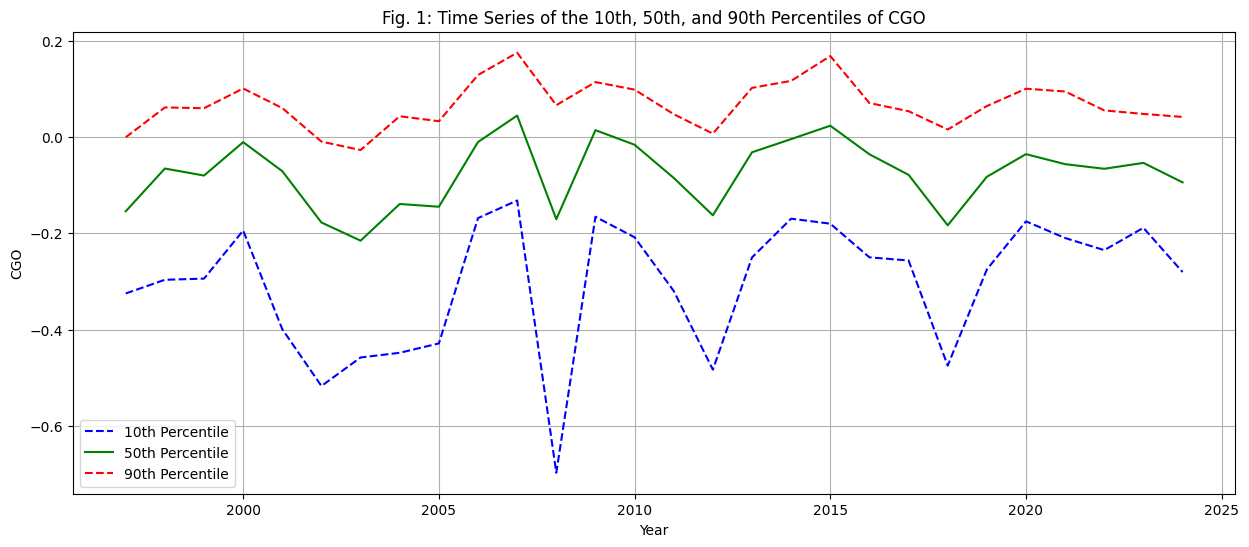

In [38]:
# Plot the time series of the 10th, 50th, and 90th percentiles of the cross section of the CGO of all individual stocks. 

'''
    Consistent with Grinblatt and Han (2005), there is a fair amount of time-series variation in CGO.
    More important, there is wide cross-sectional dispersion in CGO, which is necessary for our analysis 
    of the heterogeneity of the risk-return trade-off across firms with different levels of CGO.
'''

# Group by year and calculate the 10th, 50th, and 90th percentiles
analyze_df['year'] = analyze_df['date'].dt.year
percentiles = analyze_df.groupby('year')['Lagged_CGO'].quantile([0.1, 0.5, 0.9]).unstack()
percentiles.columns = ['10th Percentile', '50th Percentile', '90th Percentile']
analyze_df.drop(columns=['year'], inplace=True)

plt.figure(figsize=(15, 6))
plt.plot(percentiles.index, percentiles['10th Percentile'], label='10th Percentile', color='blue', linestyle='--')
plt.plot(percentiles.index, percentiles['50th Percentile'], label='50th Percentile', color='green')
plt.plot(percentiles.index, percentiles['90th Percentile'], label='90th Percentile', color='red', linestyle='--')

plt.title('Fig. 1: Time Series of the 10th, 50th, and 90th Percentiles of CGO')
plt.xlabel('Year')
plt.ylabel('CGO')
plt.legend()
plt.grid(True)

plt.show()
 

## 3.2. Dependent Double Sort

In [18]:
# Load the market_capitalization data for value-weighted portfolio return calculation
mcap = pd.read_pickle('../raw_data/mcap.pkl')

stock_mask = analyze_df['asset'].unique()

# Preprocess mcap
mcap = mcap.stack()
mcap.index.names = ['date', 'asset']
mcap = mcap.reset_index()

mcap['date'] = pd.to_datetime(mcap['date'])
mcap.rename(columns={0: 'mkt_cap'}, inplace=True)

mcap['asset'] = mcap['asset'].astype(str)
mcap['asset'] = mcap['asset'].str.extract(r'(\d+)')
mcap['asset'] = mcap['asset'].astype(int)

# Mask the stocks that are not in the stock_mask
print('Before masking:', len(mcap['asset'].unique()))
mcap = mcap[mcap['asset'].isin(stock_mask)]
print('After masking:', len(mcap['asset'].unique()))

stk_diff2 = set(stock_mask) - set(mcap['asset'].unique())
print(f'No record for stocks: {stk_diff2}, should exclude them from the monthly_CGO_df')

# Add a column named 'year_month' to align with the 'year_month' column in the monthly_CGO_df DataFrame
mcap['year_month'] = mcap['date'].dt.to_period('M')

mcap.sort_values(by=['asset', 'date'], inplace=True)
mcap.reset_index(drop=True, inplace=True) 

mcap

Before masking: 5629
After masking: 1928
No record for stocks: set(), should exclude them from the monthly_CGO_df


,date,asset,mkt_cap,year_month
0,1995-01-31,1,4.543463e+09,1995-01
1,1995-02-28,1,4.582260e+09,1995-02
2,1995-03-31,1,4.638299e+09,1995-03
3,1995-04-30,1,4.177055e+09,1995-04
4,1995-05-31,1,4.224473e+09,1995-05
...,...,...,...,...
497968,2024-04-30,603167,4.419341e+09,2024-04
497969,2024-05-31,603167,4.189460e+09,2024-05
497970,2024-06-30,603167,3.832911e+09,2024-06
497971,2024-07-31,603167,3.753156e+09,2024-07


In [19]:
# Dependent double sort the stocks first by CGO, then by 5 different risk proxies, divide them into 5*5 = 25 portfolios

# First stage sort by CGO
double_sort_df = analyze_df.copy()

# Merge with mcap
double_sort_df = double_sort_df.merge(mcap[['asset', 'year_month', 'mkt_cap']], on=['asset', 'year_month'], how='left')

# Calculate each asset's monthly_excess_return
double_sort_df['Excess_return'] = double_sort_df['monthly_return'] - double_sort_df['RF']

# Create five portfolios sorted by Capital Gains Overhang (CGO) within each month
double_sort_df['CGO_Portfolio'] = double_sort_df.groupby('year_month')['Lagged_CGO'].transform(lambda x: pd.qcut(x, q=5, labels=['1', '2', '3', '4', '5']))

double_sort_df

,date,asset,monthly_return,year_month,RF,MKT,SMB,HML,RMW,CMA,beta,RETVOL,IVOL,1/AGE,CFVOL,CGO,Lagged_CGO,mkt_cap,Excess_return,CGO_Portfolio
0,2014-05-31,1,0.032316,2014-05,0.002860,0.012071,0.049909,-0.009336,-0.025724,0.014740,1.269429,0.108818,0.008784,0.043179,2.951568e+10,-0.041630,-0.080936,1.094886e+11,0.029456,3
1,2014-06-30,1,0.048693,2014-06,0.002629,0.023325,0.059304,-0.031413,-0.011551,-0.008008,1.249432,0.105207,0.006616,0.043026,2.889618e+10,-0.203970,-0.041630,1.132207e+11,0.046063,3
2,2014-07-31,1,0.096872,2014-07,0.002993,0.077161,0.004051,0.097956,-0.008812,0.063178,1.245327,0.102765,0.007705,0.042870,2.831412e+10,-0.212463,-0.203970,1.241886e+11,0.093879,1
3,2014-08-31,1,-0.057038,2014-08,0.002699,0.011663,0.100103,-0.082468,-0.070095,-0.020470,1.193188,0.094884,0.006185,0.042714,2.776588e+10,-0.096898,-0.212463,1.171052e+11,-0.059737,1
4,2014-09-30,1,-0.010732,2014-09,0.002662,0.069617,0.177752,-0.045337,-0.102925,0.047688,1.147390,0.094100,0.005571,0.042565,2.724684e+10,-0.107107,-0.096898,1.158484e+11,-0.013394,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336380,2024-04-30,603167,0.092807,2024-04,0.001133,0.014445,-0.083869,0.025769,0.064231,-0.036332,0.982898,0.156065,0.015626,0.085860,1.516876e+08,0.024059,-0.008078,4.419341e+09,0.091675,4
336381,2024-05-31,603167,0.002963,2024-05,0.001080,-0.008524,-0.003845,0.058808,0.020994,0.001726,1.000729,0.156017,0.026043,0.085239,1.537702e+08,0.020328,0.024059,4.189460e+09,0.001883,5
336382,2024-06-30,603167,-0.085494,2024-06,0.001008,-0.032718,-0.070248,0.043358,0.049527,-0.050652,1.031479,0.156499,0.013352,0.084647,1.538537e+08,-0.132324,0.020328,3.832911e+09,-0.086502,5
336383,2024-07-31,603167,-0.020808,2024-07,0.001195,-0.000796,0.035614,0.055507,-0.065557,0.030404,1.030527,0.156314,0.013735,0.084043,1.538561e+08,-0.151224,-0.132324,3.753156e+09,-0.022003,2


In [20]:
# Then we sort the stocks in each CGO portfolio by 5 different risk proxies, creating 5 different risk-sorted portfolios within each CGO portfolio

risk_proxies = ['beta', 'RETVOL', 'IVOL', '1/AGE', 'CFVOL']

for i in risk_proxies:
    double_sort_df[f'{i}_Portfolio'] = double_sort_df.groupby(['year_month', 'CGO_Portfolio'])[i].transform(lambda x: pd.qcut(x, q=5, labels=['1', '2', '3', '4', '5'])) 

double_sort_df.drop(columns=['monthly_return', 'RF', 'RMW', 'CMA', 'IVOL', 'CFVOL', 'RETVOL', '1/AGE', 'CGO'], inplace=True)

double_sort_df

,date,asset,year_month,MKT,SMB,HML,beta,Lagged_CGO,mkt_cap,Excess_return,CGO_Portfolio,beta_Portfolio,RETVOL_Portfolio,IVOL_Portfolio,1/AGE_Portfolio,CFVOL_Portfolio
0,2014-05-31,1,2014-05,0.012071,0.049909,-0.009336,1.269429,-0.080936,1.094886e+11,0.029456,3,5,2,1,1,5
1,2014-06-30,1,2014-06,0.023325,0.059304,-0.031413,1.249432,-0.041630,1.132207e+11,0.046063,3,4,2,1,1,5
2,2014-07-31,1,2014-07,0.077161,0.004051,0.097956,1.245327,-0.203970,1.241886e+11,0.093879,1,4,1,2,1,5
3,2014-08-31,1,2014-08,0.011663,0.100103,-0.082468,1.193188,-0.212463,1.171052e+11,-0.059737,1,3,1,1,1,5
4,2014-09-30,1,2014-09,0.069617,0.177752,-0.045337,1.147390,-0.096898,1.158484e+11,-0.013394,1,3,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336380,2024-04-30,603167,2024-04,0.014445,-0.083869,0.025769,0.982898,-0.008078,4.419341e+09,0.091675,4,3,4,2,5,2
336381,2024-05-31,603167,2024-05,-0.008524,-0.003845,0.058808,1.000729,0.024059,4.189460e+09,0.001883,5,3,5,4,5,1
336382,2024-06-30,603167,2024-06,-0.032718,-0.070248,0.043358,1.031479,0.020328,3.832911e+09,-0.086502,5,3,5,2,5,1
336383,2024-07-31,603167,2024-07,-0.000796,0.035614,0.055507,1.030527,-0.132324,3.753156e+09,-0.022003,2,3,5,4,5,2


In [21]:
# For each risk proxy, Calculate the mkt_cap value-weighted excess returns time-series for each portfolio in the 25 portfolios

def calculate_value_weighted_returns(data, asset_column, excess_return_column, mkt_cap_column, CGO_porfolio_column, proxy_portfolio_column):
    """
            The value-weighted return for each portfolio in each month is calculated as 
        the sum of the product of the excess return and the market capitalization of each stock in the portfolio,
        divided by the sum of the market capitalization of all stocks in the portfolio
    """
    # Calculate the value-weighted returns for each portfolio
    value_weighted_returns = (
        data
        .groupby(['year_month', CGO_porfolio_column, proxy_portfolio_column])
        .apply(lambda x: (x[excess_return_column] * x[mkt_cap_column]).sum() / x[mkt_cap_column].sum())
        .reset_index(name='value_weighted_return')
    )
    
    return value_weighted_returns


# Calculate time-series returns for the 5 proxies
CGO_beta_returns = calculate_value_weighted_returns(double_sort_df, 'asset', 'Excess_return', 'mkt_cap', 'CGO_Portfolio', 'beta_Portfolio')
CGO_RETVOL_returns = calculate_value_weighted_returns(double_sort_df, 'asset', 'Excess_return', 'mkt_cap', 'CGO_Portfolio', 'RETVOL_Portfolio')
CGO_IVOL_returns = calculate_value_weighted_returns(double_sort_df, 'asset', 'Excess_return', 'mkt_cap', 'CGO_Portfolio', 'IVOL_Portfolio')
CGO_AGE_returns = calculate_value_weighted_returns(double_sort_df, 'asset', 'Excess_return', 'mkt_cap', 'CGO_Portfolio', '1/AGE_Portfolio')
CGO_CFVOL_returns = calculate_value_weighted_returns(double_sort_df, 'asset', 'Excess_return', 'mkt_cap', 'CGO_Portfolio', 'CFVOL_Portfolio')
# After calculating the time-series, we take the mean of each group to get the average return of each portfolio
avg_CGO_beta_returns = CGO_beta_returns.drop(columns='year_month').groupby(['CGO_Portfolio', 'beta_Portfolio']).mean().reset_index()
avg_CGO_RETVOL_returns = CGO_RETVOL_returns.groupby(['CGO_Portfolio', 'RETVOL_Portfolio']).mean().reset_index()
avg_CGO_IVOL_returns = CGO_IVOL_returns.groupby(['CGO_Portfolio', 'IVOL_Portfolio']).mean().reset_index()
avg_CGO_AGE_returns = CGO_AGE_returns.groupby(['CGO_Portfolio', '1/AGE_Portfolio']).mean().reset_index()
avg_CGO_CFVOL_returns = CGO_CFVOL_returns.groupby(['CGO_Portfolio', 'CFVOL_Portfolio']).mean().reset_index()


# Store the into lists for further analysis
returns = [CGO_beta_returns, CGO_RETVOL_returns, CGO_IVOL_returns, CGO_AGE_returns, CGO_CFVOL_returns]
avg_returns = [avg_CGO_beta_returns, avg_CGO_RETVOL_returns, avg_CGO_IVOL_returns, avg_CGO_AGE_returns, avg_CGO_CFVOL_returns]

In [39]:
for i, j in zip(range(5), risk_proxies):
    pivot_table = avg_returns[i].pivot(index=f'{j}_Portfolio', columns='CGO_Portfolio', values='value_weighted_return')
    pivot_table = (pivot_table * 100).round(3)
    print(pivot_table)

CGO_Portfolio       1      2      3      4      5
beta_Portfolio                                   
1               1.393  1.442  1.535  1.094  1.758
2               1.632  1.391  1.638  1.184  1.474
3               1.583  1.242  1.797  1.642  1.712
4               1.903  1.421  1.378  1.344  1.791
5               2.306  1.873  1.649  1.766  1.784
CGO_Portfolio         1      2      3      4      5
RETVOL_Portfolio                                   
1                 1.239  1.078  1.301  0.932  1.372
2                 1.438  1.303  1.444  1.250  1.237
3                 1.859  1.481  1.520  1.360  1.715
4                 2.059  1.654  2.000  1.650  1.604
5                 2.357  1.917  2.116  2.132  2.508
CGO_Portfolio       1      2      3      4      5
IVOL_Portfolio                                   
1               1.243  1.592  1.436  1.596  1.974
2               1.939  1.523  1.904  1.717  1.938
3               1.902  1.455  1.616  1.577  1.819
4               1.847  1.512  1.595 

In [22]:
# Calculate p5 - p1 spread for each proxy within each CGO portfolio
CGO_beta_returns['p5_p1'] = CGO_beta_returns.groupby(['year_month', 'CGO_Portfolio'])['value_weighted_return'].transform(lambda x: x.diff(4))
CGO_RETVOL_returns['p5_p1'] = CGO_RETVOL_returns.groupby(['year_month', 'CGO_Portfolio'])['value_weighted_return'].transform(lambda x: x.diff(4))
CGO_IVOL_returns['p5_p1'] = CGO_IVOL_returns.groupby(['year_month', 'CGO_Portfolio'])['value_weighted_return'].transform(lambda x: x.diff(4))
CGO_AGE_returns['p5_p1'] = CGO_AGE_returns.groupby(['year_month', 'CGO_Portfolio'])['value_weighted_return'].transform(lambda x: x.diff(4))
CGO_CFVOL_returns['p5_p1'] = CGO_CFVOL_returns.groupby(['year_month', 'CGO_Portfolio'])['value_weighted_return'].transform(lambda x: x.diff(4))
# Extract out the needed columns for each spread
CGO_beta_spread = CGO_beta_returns[['year_month', 'CGO_Portfolio', 'p5_p1']].dropna().reset_index(drop=True)
CGO_RETVOL_spread = CGO_RETVOL_returns[['year_month', 'CGO_Portfolio', 'p5_p1']].dropna().reset_index(drop=True)
CGO_IVOL_spread = CGO_IVOL_returns[['year_month', 'CGO_Portfolio', 'p5_p1']].dropna().reset_index(drop=True)
CGO_AGE_spread = CGO_AGE_returns[['year_month', 'CGO_Portfolio', 'p5_p1']].dropna().reset_index(drop=True)
CGO_CFVOL_spread = CGO_CFVOL_returns[['year_month', 'CGO_Portfolio', 'p5_p1']].dropna().reset_index(drop=True)
# Drop temporary column in the returns df
CGO_beta_returns.drop(columns='p5_p1', inplace=True)
CGO_RETVOL_returns.drop(columns='p5_p1', inplace=True)
CGO_IVOL_returns.drop(columns='p5_p1', inplace=True)
CGO_AGE_returns.drop(columns='p5_p1', inplace=True)
CGO_CFVOL_returns.drop(columns='p5_p1', inplace=True)

# Store into lists
spreads_returns = [CGO_beta_spread, CGO_RETVOL_spread, CGO_IVOL_spread, CGO_AGE_spread, CGO_CFVOL_spread]

In [23]:
# Prepare the Diff-in-Diff df for each proxy groupby year_month and CGO_Portfolio: Diff-in-Diff = (P5-P1_CGO5 − P5-P1_CGO1)
CGO_beta_spread['Diff_in_Diff'] = CGO_beta_spread.groupby('year_month')['p5_p1'].transform(lambda x: x.diff(4))
CGO_RETVOL_spread['Diff_in_Diff'] = CGO_RETVOL_spread.groupby('year_month')['p5_p1'].transform(lambda x: x.diff(4))
CGO_IVOL_spread['Diff_in_Diff'] = CGO_IVOL_spread.groupby('year_month')['p5_p1'].transform(lambda x: x.diff(4))
CGO_AGE_spread['Diff_in_Diff'] = CGO_AGE_spread.groupby('year_month')['p5_p1'].transform(lambda x: x.diff(4))
CGO_CFVOL_spread['Diff_in_Diff'] = CGO_CFVOL_spread.groupby('year_month')['p5_p1'].transform(lambda x: x.diff(4))

# Extract out the needed columns
CGO_beta_diff_in_diff = CGO_beta_spread[['year_month', 'Diff_in_Diff']].dropna().reset_index(drop=True)
CGO_RETVOL_diff_in_diff = CGO_RETVOL_spread[['year_month', 'Diff_in_Diff']].dropna().reset_index(drop=True)
CGO_IVOL_diff_in_diff = CGO_IVOL_spread[['year_month', 'Diff_in_Diff']].dropna().reset_index(drop=True)
CGO_AGE_diff_in_diff = CGO_AGE_spread[['year_month', 'Diff_in_Diff']].dropna().reset_index(drop=True)
CGO_CFVOL_diff_in_diff = CGO_CFVOL_spread[['year_month', 'Diff_in_Diff']].dropna().reset_index(drop=True)
# Drop temporary column in the spread df
CGO_beta_spread.drop(columns='Diff_in_Diff', inplace=True)
CGO_RETVOL_spread.drop(columns='Diff_in_Diff', inplace=True)
CGO_IVOL_spread.drop(columns='Diff_in_Diff', inplace=True)
CGO_AGE_spread.drop(columns='Diff_in_Diff', inplace=True)
CGO_CFVOL_spread.drop(columns='Diff_in_Diff', inplace=True)

# Store into lists
diff_in_diff_returns = [CGO_beta_diff_in_diff, CGO_RETVOL_diff_in_diff, CGO_IVOL_diff_in_diff, CGO_AGE_diff_in_diff, CGO_CFVOL_diff_in_diff]

normal_returns_diff_in_diff_results = []
# Avg returns for diff_in_diff
for i in range(len(diff_in_diff_returns)):
    avg = diff_in_diff_returns[i]['Diff_in_Diff'].mean()
    t_stat = avg / diff_in_diff_returns[i]['Diff_in_Diff'].std() * np.sqrt(len(diff_in_diff_returns[i]))
    result = {'Proxy': risk_proxies[i], 'normal_returns_diff_in_diff': avg, 'normal_t_stat_diff_in_diff': t_stat}
    normal_returns_diff_in_diff_results.append(result)

for i in normal_returns_diff_in_diff_results:
    print(i)

{'Proxy': 'beta', 'normal_returns_diff_in_diff': np.float64(-0.00886483273334546), 'normal_t_stat_diff_in_diff': np.float64(-2.0167398256888927)}
{'Proxy': 'RETVOL', 'normal_returns_diff_in_diff': np.float64(0.00018039465946083157), 'normal_t_stat_diff_in_diff': np.float64(0.0331190634756117)}
{'Proxy': 'IVOL', 'normal_returns_diff_in_diff': np.float64(-0.008388554576061755), 'normal_t_stat_diff_in_diff': np.float64(-1.7953482410615074)}
{'Proxy': '1/AGE', 'normal_returns_diff_in_diff': np.float64(0.013107867676547048), 'normal_t_stat_diff_in_diff': np.float64(3.3776530331359824)}
{'Proxy': 'CFVOL', 'normal_returns_diff_in_diff': np.float64(0.008177922706464946), 'normal_t_stat_diff_in_diff': np.float64(1.8670588922927172)}


In [24]:
'''
    Normal average return and t-statistic calculation
'''
# After calculating the time-series for each spread, we take the mean of each group to get the average return of each spread
avg_CGO_beta_spread = CGO_beta_spread.groupby('CGO_Portfolio').mean()
avg_CGO_RETVOL_spread = CGO_RETVOL_spread.groupby('CGO_Portfolio').mean()
avg_CGO_IVOL_spread = CGO_IVOL_spread.groupby('CGO_Portfolio').mean()
avg_CGO_AGE_spread = CGO_AGE_spread.groupby('CGO_Portfolio').mean()
avg_CGO_CFVOL_spread = CGO_CFVOL_spread.groupby('CGO_Portfolio').mean()
# Calculate the t-statistic for each spread on normal p5 - p1 returns
t_CGO_beta_spread = CGO_beta_spread.groupby('CGO_Portfolio').apply(lambda x: x['p5_p1'].mean() / x['p5_p1'].std() * np.sqrt(len(x))).to_frame(name='normal_t_stat').reset_index()
t_CGO_RETVOL_spread = CGO_RETVOL_spread.groupby('CGO_Portfolio').apply(lambda x: x['p5_p1'].mean() / x['p5_p1'].std() * np.sqrt(len(x))).to_frame(name='normal_t_stat').reset_index()
t_CGO_IVOL_spread = CGO_IVOL_spread.groupby('CGO_Portfolio').apply(lambda x: x['p5_p1'].mean() / x['p5_p1'].std() * np.sqrt(len(x))).to_frame(name='normal_t_stat').reset_index()
t_CGO_AGE_spread = CGO_AGE_spread.groupby('CGO_Portfolio').apply(lambda x: x['p5_p1'].mean() / x['p5_p1'].std() * np.sqrt(len(x))).to_frame(name='normal_t_stat').reset_index()
t_CGO_CFVOL_spread = CGO_CFVOL_spread.groupby('CGO_Portfolio').apply(lambda x: x['p5_p1'].mean() / x['p5_p1'].std() * np.sqrt(len(x))).to_frame(name='normal_t_stat').reset_index()

# Merge results
spread1_result = avg_CGO_beta_spread.merge(t_CGO_beta_spread, on='CGO_Portfolio')
spread2_result = avg_CGO_RETVOL_spread.merge(t_CGO_RETVOL_spread, on='CGO_Portfolio')
spread3_result = avg_CGO_IVOL_spread.merge(t_CGO_IVOL_spread, on='CGO_Portfolio')
spread4_result = avg_CGO_AGE_spread.merge(t_CGO_AGE_spread, on='CGO_Portfolio')
spread5_result = avg_CGO_CFVOL_spread.merge(t_CGO_CFVOL_spread, on='CGO_Portfolio')

normal_returns_spreads_results = [spread1_result, spread2_result, spread3_result, spread4_result, spread5_result]

normal_returns_spreads_results

[  CGO_Portfolio year_month     p5_p1  normal_t_stat
 0             1    2011-03  0.009133       1.922852
 1             2    2011-03  0.004312       0.974758
 2             3    2011-03  0.001137       0.261603
 3             4    2011-03  0.006714       1.416969
 4             5    2011-03  0.000268       0.047657,
   CGO_Portfolio year_month     p5_p1  normal_t_stat
 0             1    2011-03  0.011176       2.321814
 1             2    2011-03  0.008396       1.956341
 2             3    2011-03  0.008154       1.848745
 3             4    2011-03  0.012004       2.657563
 4             5    2011-03  0.011357       2.054875,
   CGO_Portfolio year_month     p5_p1  normal_t_stat
 0             1    2011-03  0.003578       1.101829
 1             2    2011-03 -0.004557      -1.347603
 2             3    2011-03  0.000406       0.122489
 3             4    2011-03 -0.003947      -1.050612
 4             5    2011-03 -0.004810      -1.056517,
   CGO_Portfolio year_month     p5_p1  norm

In [25]:
''' 
    FF3-alpha and t-statistic calculation
'''
# First we merge the monthly_ff5 with the each spread, we only need ff3 factors for the FF3-alpha calculation
for i in range(0, 5):
    spreads_returns[i] = spreads_returns[i].merge(monthly_ff5[['year_month', 'MKT', 'SMB', 'HML']], on='year_month', how='left')
    

def calculate_ff3_alpha(data, excess_return_col, factors):
    """
    Calculate FF3-alpha and t-statistic for a given portfolio spread.
    
    Parameters:
        data (pd.DataFrame): A DataFrame containing the monthly excess returns and FF3 factors.
        excess_return_col (str): Name of the column with the portfolio's excess returns.
        factors (list): List of factor column names (e.g., ['Mkt_Rf', 'SMB', 'HML']).
    
    Returns:
        dict: FF3-alpha and its t-statistic.
    """
    # Set up regression
    X = data[factors]
    X = sm.add_constant(X)  # Add intercept
    y = data[excess_return_col]
    
    # Run regression
    model = sm.OLS(y, X).fit()
    
    # Extract alpha and its t-statistic
    alpha = model.params['const']
    t_stat = model.tvalues['const']
    
    return {'FF3_alpha': alpha, 'ff3_t_stat': t_stat}


ff3_returns_spreads_results = []
for i in range(0, 5):
    spread = spreads_returns[i]
    ff3_results = []
    for cgo_group in spread['CGO_Portfolio'].unique():
        cgo_data = spread[spread['CGO_Portfolio'] == cgo_group]
        
        # Run FF3 regression
        result = calculate_ff3_alpha(cgo_data, 'p5_p1', ['MKT', 'SMB', 'HML'])
        result['CGO_Portfolio'] = cgo_group
        ff3_results.append(result)

    # Convert results to a DataFrame
    ff3_results_df = pd.DataFrame(ff3_results)
    ff3_returns_spreads_results.append(ff3_results_df)

ff3_returns_spreads_results

[   FF3_alpha  ff3_t_stat CGO_Portfolio
 0   0.005266    1.521563             1
 1   0.000597    0.180151             2
 2  -0.004145   -1.282583             3
 3   0.003467    0.966116             4
 4  -0.003102   -0.719028             5,
    FF3_alpha  ff3_t_stat CGO_Portfolio
 0   0.007531    1.941181             1
 1   0.002808    0.838058             2
 2   0.002653    0.739473             3
 3   0.008592    2.263937             4
 4   0.008906    1.979190             5,
    FF3_alpha  ff3_t_stat CGO_Portfolio
 0   0.004531    1.513085             1
 1  -0.006361   -1.963418             2
 2  -0.001034   -0.349534             3
 3  -0.005574   -1.580218             4
 4  -0.007881   -1.786301             5,
    FF3_alpha  ff3_t_stat CGO_Portfolio
 0  -0.003151   -1.128766             1
 1  -0.003858   -1.368117             2
 2   0.004014    1.379138             3
 3   0.012221    3.384963             4
 4   0.009848    3.067216             5,
    FF3_alpha  ff3_t_stat CGO_Portfo

In [26]:
# Process diff_in_diff for ff3

# First we merge the monthly_ff5 with the each diff_in_diff, we only need ff3 factors for the FF3-alpha calculation
for i in range(0, 5):
    diff_in_diff_returns[i] = diff_in_diff_returns[i].merge(monthly_ff5[['year_month', 'MKT', 'SMB', 'HML']], on='year_month', how='left')

# Perform calculations
ff3_returns_diff_in_diff_results = []
for i in range(0, 5):
    data = diff_in_diff_returns[i]
    result = calculate_ff3_alpha(data, 'Diff_in_Diff', ['MKT', 'SMB', 'HML'])
    ff3_returns_diff_in_diff_results.append(result)

for i in ff3_returns_diff_in_diff_results:
    print(i)

{'FF3_alpha': np.float64(-0.008367999916220874), 'ff3_t_stat': np.float64(-1.84361066090949)}
{'FF3_alpha': np.float64(0.0013749148924636564), 'ff3_t_stat': np.float64(0.2452909791619859)}
{'FF3_alpha': np.float64(-0.012412454307949832), 'ff3_t_stat': np.float64(-2.5975408147768206)}
{'FF3_alpha': np.float64(0.012998642624331709), 'ff3_t_stat': np.float64(3.2211337785607617)}
{'FF3_alpha': np.float64(0.00878705592578505), 'ff3_t_stat': np.float64(1.9721396793313282)}


## 3.3. Fama-MacBeth Regression Test

### 3.3.1. Prepare the needed variables for the Fama-MacBeth regressions

In [27]:
# Load additional data
monthly_turnover = pd.read_csv('../raw_data/monthly_price_turnover/TRD_Mnth.csv')

monthly_turnover.rename(columns={'Stkcd': 'asset', 'Trdmnt': 'year_month', 'Mclsprc': 'monthly_close', 'Msmvosd': 'monthly_negotiable_value', 'Mnshrtrd': 'monthly_traded_shares'}, inplace=True)

# filter out the stocks
stock_mask = analyze_df['asset'].unique()
monthly_turnover['asset'] = monthly_turnover['asset'].astype(int)
monthly_turnover['year_month'] = pd.to_datetime(monthly_turnover['year_month']).dt.to_period('M')
monthly_turnover = monthly_turnover[monthly_turnover['asset'].isin(stock_mask)]

# Calculate the monthly monthly_turnover
monthly_turnover['monthly_turnover'] = (monthly_turnover['monthly_traded_shares'] / (monthly_turnover['monthly_negotiable_value'] * 1000 / monthly_turnover['monthly_close'])).round(4)
# df1 = df1.dropna()
# df1['weekly_turnover'] = df1['weekly_turnover'].astype(float)

monthly_turnover

,asset,year_month,monthly_close,monthly_traded_shares,monthly_negotiable_value,monthly_turnover
0,1,1991-04,43.68,13400,1157520.00,0.0005
1,1,1991-05,38.34,187800,1016010.00,0.0071
2,1,1991-06,33.99,30600,900735.00,0.0012
3,1,1991-07,29.54,6100,782810.00,0.0002
4,1,1991-08,15.00,3243100,674833.82,0.0721
...,...,...,...,...,...,...
720966,603167,2024-07,8.00,106722712,3753156.02,0.2275
720967,603167,2024-08,7.46,64904643,3499817.99,0.1383
720968,603167,2024-09,8.33,93707960,3907973.71,0.1997
720969,603167,2024-10,8.41,152028608,3945505.27,0.3241


In [28]:
FMB_df = analyze_df.copy().drop(columns=['CGO', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

FMB_df = FMB_df.merge(mcap[['asset', 'year_month', 'mkt_cap']], on=['asset', 'year_month'], how='left')
FMB_df = FMB_df.merge(monthly_turnover[['asset', 'year_month', 'monthly_turnover']], on=['asset', 'year_month'], how='left')

# Prepare excess return data for month t
FMB_df['Excess_return'] = FMB_df['monthly_return'] - FMB_df['RF']
FMB_df['MOM(-1,0)'] = FMB_df['monthly_return'] - FMB_df['RF']

# Calculate cumulative returns for specified periods
def calculate_momentum(data, return_col, group_col='asset_id', time_col='time'):
    """
    Calculate MOM(-12, -1) and MOM(-36, -12) based on monthly returns.
    """
    # Sort data by asset and time
    data = data.sort_values(by=[group_col, time_col])
    
    # Calculate rolling cumulative returns
    data['MOM(-12,-1)'] = data.groupby(group_col)[return_col].rolling(window=12, min_periods=12)\
                                .apply(lambda x: (np.prod(1 + pd.Series(x)) - 1), raw=True).reset_index(level=0, drop=True)
    
    return data

# Apply the function to calculate MOM(-12,-1) and MOM(-36,-12)
FMB_df = calculate_momentum(FMB_df, return_col='MOM(-1,0)', group_col='asset', time_col='year_month')


FMB_df

,date,asset,monthly_return,year_month,RF,beta,RETVOL,IVOL,1/AGE,CFVOL,Lagged_CGO,mkt_cap,monthly_turnover,Excess_return,"MOM(-1,0)","MOM(-12,-1)"
0,2014-05-31,1,0.032316,2014-05,0.002860,1.269429,0.108818,0.008784,0.043179,2.951568e+10,-0.080936,1.094886e+11,0.1262,0.029456,0.029456,NaN
1,2014-06-30,1,0.048693,2014-06,0.002629,1.249432,0.105207,0.006616,0.043026,2.889618e+10,-0.041630,1.132207e+11,0.1340,0.046063,0.046063,NaN
2,2014-07-31,1,0.096872,2014-07,0.002993,1.245327,0.102765,0.007705,0.042870,2.831412e+10,-0.203970,1.241886e+11,0.2049,0.093879,0.093879,NaN
3,2014-08-31,1,-0.057038,2014-08,0.002699,1.193188,0.094884,0.006185,0.042714,2.776588e+10,-0.212463,1.171052e+11,0.1859,-0.059737,-0.059737,NaN
4,2014-09-30,1,-0.010732,2014-09,0.002662,1.147390,0.094100,0.005571,0.042565,2.724684e+10,-0.096898,1.158484e+11,0.1318,-0.013394,-0.013394,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336380,2024-04-30,603167,0.092807,2024-04,0.001133,0.982898,0.156065,0.015626,0.085860,1.516876e+08,-0.008078,4.419341e+09,0.5482,0.091675,0.091675,0.288930
336381,2024-05-31,603167,0.002963,2024-05,0.001080,1.000729,0.156017,0.026043,0.085239,1.537702e+08,0.024059,4.189460e+09,0.4623,0.001883,0.001883,0.331013
336382,2024-06-30,603167,-0.085494,2024-06,0.001008,1.031479,0.156499,0.013352,0.084647,1.538537e+08,0.020328,3.832911e+09,0.2619,-0.086502,-0.086502,0.225898
336383,2024-07-31,603167,-0.020808,2024-07,0.001195,1.030527,0.156314,0.013735,0.084043,1.538561e+08,-0.132324,3.753156e+09,0.2275,-0.022003,-0.022003,0.136497


In [29]:
# lag by 1
columms = ['beta', 'RETVOL', 'IVOL', '1/AGE', 'CFVOL', 'monthly_turnover', 'MOM(-1,0)', 'MOM(-12,-1)']
for i in columms:
    FMB_df[i] = FMB_df.groupby('asset')[i].shift(1)
FMB_df


,date,asset,monthly_return,year_month,RF,beta,RETVOL,IVOL,1/AGE,CFVOL,Lagged_CGO,mkt_cap,monthly_turnover,Excess_return,"MOM(-1,0)","MOM(-12,-1)"
0,2014-05-31,1,0.032316,2014-05,0.002860,NaN,NaN,NaN,NaN,NaN,-0.080936,1.094886e+11,NaN,0.029456,NaN,NaN
1,2014-06-30,1,0.048693,2014-06,0.002629,1.269429,0.108818,0.008784,0.043179,2.951568e+10,-0.041630,1.132207e+11,0.1262,0.046063,0.029456,NaN
2,2014-07-31,1,0.096872,2014-07,0.002993,1.249432,0.105207,0.006616,0.043026,2.889618e+10,-0.203970,1.241886e+11,0.1340,0.093879,0.046063,NaN
3,2014-08-31,1,-0.057038,2014-08,0.002699,1.245327,0.102765,0.007705,0.042870,2.831412e+10,-0.212463,1.171052e+11,0.2049,-0.059737,0.093879,NaN
4,2014-09-30,1,-0.010732,2014-09,0.002662,1.193188,0.094884,0.006185,0.042714,2.776588e+10,-0.096898,1.158484e+11,0.1859,-0.013394,-0.059737,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336380,2024-04-30,603167,0.092807,2024-04,0.001133,0.972654,0.155693,0.020986,0.086470,1.494813e+08,-0.008078,4.419341e+09,0.3033,0.091675,-0.058138,0.187276
336381,2024-05-31,603167,0.002963,2024-05,0.001080,0.982898,0.156065,0.015626,0.085860,1.516876e+08,0.024059,4.189460e+09,0.5482,0.001883,0.091675,0.288930
336382,2024-06-30,603167,-0.085494,2024-06,0.001008,1.000729,0.156017,0.026043,0.085239,1.537702e+08,0.020328,3.832911e+09,0.4623,-0.086502,0.001883,0.331013
336383,2024-07-31,603167,-0.020808,2024-07,0.001195,1.031479,0.156499,0.013352,0.084647,1.538537e+08,-0.132324,3.753156e+09,0.2619,-0.022003,-0.086502,0.225898


In [30]:
FMB_df.dropna(inplace=True)

FMB_df.reset_index(drop=True, inplace=True)

FMB_df

,date,asset,monthly_return,year_month,RF,beta,RETVOL,IVOL,1/AGE,CFVOL,Lagged_CGO,mkt_cap,monthly_turnover,Excess_return,"MOM(-1,0)","MOM(-12,-1)"
0,2015-05-31,1,-0.082635,2015-05,0.001834,1.220954,0.106398,0.012874,0.041539,3.228236e+10,0.053108,2.192089e+11,0.4979,-0.084468,0.280628,1.143147
1,2015-06-30,1,-0.050914,2015-06,0.001739,1.163410,0.105002,0.026618,0.041393,3.451247e+10,0.045600,2.080482e+11,0.3393,-0.052653,-0.084468,0.905976
2,2015-07-31,1,-0.149931,2015-07,0.002002,1.182109,0.105351,0.007985,0.041253,3.743284e+10,-0.067686,1.768552e+11,0.4132,-0.151933,-0.052653,0.726110
3,2015-08-31,1,-0.104369,2015-08,0.001793,1.223277,0.107509,0.012046,0.041109,3.984362e+10,-0.118767,1.583970e+11,0.4434,-0.106161,-0.151933,0.338226
4,2015-09-30,1,-0.052394,2015-09,0.001711,1.190183,0.108581,0.014084,0.040966,4.186660e+10,-0.265940,1.500980e+11,0.1978,-0.054105,-0.106161,0.272153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313244,2024-04-30,603167,0.092807,2024-04,0.001133,0.972654,0.155693,0.020986,0.086470,1.494813e+08,-0.008078,4.419341e+09,0.3033,0.091675,-0.058138,0.187276
313245,2024-05-31,603167,0.002963,2024-05,0.001080,0.982898,0.156065,0.015626,0.085860,1.516876e+08,0.024059,4.189460e+09,0.5482,0.001883,0.091675,0.288930
313246,2024-06-30,603167,-0.085494,2024-06,0.001008,1.000729,0.156017,0.026043,0.085239,1.537702e+08,0.020328,3.832911e+09,0.4623,-0.086502,0.001883,0.331013
313247,2024-07-31,603167,-0.020808,2024-07,0.001195,1.031479,0.156499,0.013352,0.084647,1.538537e+08,-0.132324,3.753156e+09,0.2619,-0.022003,-0.086502,0.225898


In [31]:
FMB_df.rename(columns={'Lagged_CGO': 'CGO'}, inplace=True)

temp = ['beta', 'RETVOL', 'IVOL', '1/AGE', 'CFVOL']
multiplier = ['CGO', 'MOM(-12,-1)']

for i in temp:
    for j in multiplier:
        if i != j:
            FMB_df[f'{i}*{j}'] = FMB_df[i] * FMB_df[j]

FMB_df

,date,asset,monthly_return,year_month,RF,beta,RETVOL,IVOL,1/AGE,CFVOL,...,beta*CGO,"beta*MOM(-12,-1)",RETVOL*CGO,"RETVOL*MOM(-12,-1)",IVOL*CGO,"IVOL*MOM(-12,-1)",1/AGE*CGO,"1/AGE*MOM(-12,-1)",CFVOL*CGO,"CFVOL*MOM(-12,-1)"
0,2015-05-31,1,-0.082635,2015-05,0.001834,1.220954,0.106398,0.012874,0.041539,3.228236e+10,...,0.064842,1.395729,0.005651,0.121628,0.000684,0.014717,0.002206,0.047485,1.714442e+09,3.690348e+10
1,2015-06-30,1,-0.050914,2015-06,0.001739,1.163410,0.105002,0.026618,0.041393,3.451247e+10,...,0.053051,1.054021,0.004788,0.095129,0.001214,0.024116,0.001888,0.037501,1.573763e+09,3.126748e+10
2,2015-07-31,1,-0.149931,2015-07,0.002002,1.182109,0.105351,0.007985,0.041253,3.743284e+10,...,-0.080012,0.858341,-0.007131,0.076496,-0.000540,0.005798,-0.002792,0.029954,-2.533671e+09,2.718036e+10
3,2015-08-31,1,-0.104369,2015-08,0.001793,1.223277,0.107509,0.012046,0.041109,3.984362e+10,...,-0.145285,0.413744,-0.012769,0.036362,-0.001431,0.004074,-0.004882,0.013904,-4.732101e+09,1.347615e+10
4,2015-09-30,1,-0.052394,2015-09,0.001711,1.190183,0.108581,0.014084,0.040966,4.186660e+10,...,-0.316517,0.323912,-0.028876,0.029551,-0.003745,0.003833,-0.010894,0.011149,-1.113399e+10,1.139411e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313244,2024-04-30,603167,0.092807,2024-04,0.001133,0.972654,0.155693,0.020986,0.086470,1.494813e+08,...,-0.007857,0.182155,-0.001258,0.029158,-0.000170,0.003930,-0.000699,0.016194,-1.207519e+06,2.799431e+07
313245,2024-05-31,603167,0.002963,2024-05,0.001080,0.982898,0.156065,0.015626,0.085860,1.516876e+08,...,0.023648,0.283989,0.003755,0.045092,0.000376,0.004515,0.002066,0.024808,3.649476e+06,4.382716e+07
313246,2024-06-30,603167,-0.085494,2024-06,0.001008,1.000729,0.156017,0.026043,0.085239,1.537702e+08,...,0.020343,0.331254,0.003171,0.051644,0.000529,0.008620,0.001733,0.028215,3.125817e+06,5.089987e+07
313247,2024-07-31,603167,-0.020808,2024-07,0.001195,1.031479,0.156499,0.013352,0.084647,1.538537e+08,...,-0.136489,0.233010,-0.020709,0.035353,-0.001767,0.003016,-0.011201,0.019122,-2.035851e+07,3.475531e+07


### 3.3.2. Conduct the Fama-MacBeth regressions on the 5 different risk proxies

In [32]:
# Winsorization function to handle outliers
def winsorize_series(series, lower_percentile=0.01, upper_percentile=0.99):
    lower = series.quantile(lower_percentile)
    upper = series.quantile(upper_percentile)
    return series.clip(lower=lower, upper=upper)


# Winsorize independent variables
for col in ['CGO', 'beta', 'RETVOL', 'IVOL', '1/AGE', 'CFVOL', 'MOM(-1,0)', 'MOM(-12,-1)', 'beta*CGO', 'beta*MOM(-12,-1)',
            'RETVOL*CGO', 'RETVOL*MOM(-12,-1)', 'IVOL*CGO', 'IVOL*MOM(-12,-1)', '1/AGE*CGO',
            '1/AGE*MOM(-12,-1)', 'CFVOL*CGO', 'CFVOL*MOM(-12,-1)', 'monthly_turnover']:
    FMB_df[col] = winsorize_series(FMB_df[col])

# Define risk proxies and their corresponding independent variables
risk_proxies = ['beta', 'RETVOL', 'IVOL', '1/AGE', 'CFVOL']

In [33]:
from linearmodels import FamaMacBeth

# 将数据转换为适合的格式
data = FMB_df.copy()
data = data.set_index(['year_month', 'asset'])

# 定义被解释变量和解释变量
y = data['Excess_return']
X = data[['CGO', 'MOM(-1,0)', 'MOM(-12,-1)', 'monthly_turnover']]

# 添加常数项
X = sm.add_constant(X)

# 进行Fama-MacBeth回归
model = FamaMacBeth(y, X)
results = model.fit(cov_type='kernel', kernel='bartlett', bandwidth=12) # 使用Bartlett核进行Newey-West调整

# 输出结果
print(results.summary)


                            FamaMacBeth Estimation Summary                           
Dep. Variable:               Excess_return   R-squared:                       -0.0053
Estimator:                     FamaMacBeth   R-squared (Between):             -0.0281
No. Observations:                   313249   R-squared (Within):               0.0021
Date:                     Sun, Dec 15 2024   R-squared (Overall):             -0.0053
Time:                             01:28:19   Log-likelihood                 1.769e+05
Cov. Estimator:    Fama-MacBeth Kernel Cov                                           
                                             F-statistic:                     -416.12
Entities:                              310   P-value                           1.0000
Avg Obs:                            1010.5   Distribution:                F(4,313244)
Min Obs:                            152.00                                           
Max Obs:                            1724.0   F-statist

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data1 = FMB_df.copy()
data1 = data1.set_index(['year_month', 'asset'])

risk_proxies_1 = ['beta', 'RETVOL', 'IVOL', '1/AGE', 'CFVOL']

proxy_results = {}

for proxy in risk_proxies_1:
    # 定义模型的解释变量
    models_1 = {
        'Column 2': ['CGO', proxy, 'MOM(-1,0)', 'MOM(-12,-1)', 'monthly_turnover'],
        'Column 3': ['CGO', proxy, f'{proxy}*CGO', 'MOM(-1,0)', 'MOM(-12,-1)', 'monthly_turnover'],
        'Column 4': ['CGO', proxy, f'{proxy}*CGO', f'{proxy}*MOM(-12,-1)', 'MOM(-1,0)', 'MOM(-12,-1)', 'monthly_turnover']
    }
    
    # print(models_1)
    
    for column, variables in models_1.items():
        # 提取被解释变量和解释变量
        y = data1['Excess_return']
        X = data1[variables]
        
        # 添加常数项
        X = sm.add_constant(X)
        
        # print(X.columns)
        # 进行Fama-MacBeth回归
        try:
            model = FamaMacBeth(y, X)
        except ValueError as e:
            # need to scale the data, here only the CFVOL risk proxy will cause this problem
            if column == 'Column 2':
                column_to_scale = ['CFVOL']
            elif column == 'Column 3':
                column_to_scale = ['CFVOL', 'CFVOL*CGO']
            elif column == 'Column 4':
                column_to_scale = ['CFVOL', 'CFVOL*CGO', 'CFVOL*MOM(-12,-1)']
                
            scaler_minmax = MinMaxScaler(feature_range=(-50, 50))
            X[column_to_scale] = scaler_minmax.fit_transform(X[column_to_scale])

            scaler = StandardScaler()
            X[column_to_scale] = scaler.fit_transform(X[column_to_scale])
            
            model = FamaMacBeth(y, X)
            
        proxy_result = model.fit(cov_type='kernel', kernel='bartlett', bandwidth=12)
        
        print('////////////////////////////////////////////////////////////////////')
        print(f'{proxy} - {column}')
        print(proxy_result.summary)
        

////////////////////////////////////////////////////////////////////
beta - Column 2
                            FamaMacBeth Estimation Summary                           
Dep. Variable:               Excess_return   R-squared:                       -0.0076
Estimator:                     FamaMacBeth   R-squared (Between):             -0.0298
No. Observations:                   313249   R-squared (Within):               0.0002
Date:                     Sun, Dec 15 2024   R-squared (Overall):             -0.0076
Time:                             01:28:21   Log-likelihood                 1.766e+05
Cov. Estimator:    Fama-MacBeth Kernel Cov                                           
                                             F-statistic:                     -471.84
Entities:                              310   P-value                           1.0000
Avg Obs:                            1010.5   Distribution:                F(5,313243)
Min Obs:                            152.00             

In [35]:
# Get the date range in the analyze_df
start_date = analyze_df['date'].min()
end_date = analyze_df['date'].max()

print(start_date)
print(end_date)

1997-11-30 00:00:00
2024-08-31 00:00:00
